# Lab 1 : First order methods on regression models

#### Authors: A. Gramfort, R. Gower, P. Ablin

## Aim

The aim of this material is to code 
- proximal gradient descent (ISTA)
- accelerated gradient descent (FISTA) 

for 
- linear regression
- logistic regression 

models.

The proximal operators we will use are the 
- ridge penalization
- L1 penalization

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 7th of october at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 2 octobre 2017**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [80]:
# Change here using YOUR first and last names
fn1 = "Yu"
ln1 = "Xiang"
fn2 = "Jean"
ln2 = "Babin"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab1", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab1_xiang_yu_and_babin_jean.ipynb


In [81]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse vectors and simulating data

### Getting sparse coefficients

In [82]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

Text(0.5,1,'Parameters / Coefficients')

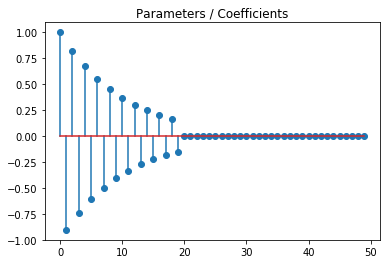

In [83]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = ((-1) ** idx) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

### Functions for the simulation of the models

In [84]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn
from numpy.linalg import norm


def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + randn(n_samples)
    return A, b

def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))

def simu_logreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(A.dot(coefs))
    b = np.random.binomial(1, p, size=n_samples)
    b = 2 * b - 1
    return A, b

## Part 1 : Proximal operators

We remind that the proximal operator of a fonction $g$ is given by:

$$
\text{prox}_g(x) = \arg\min_z \left\{ \frac{1}{2} \Vert x - z\Vert_2^2 + g(z) \right\}.
$$


We have in mind to use the following cases

- Ridge penalization, where $g(z) = \frac{s}{2} \|z\|_2^2$
- Lasso penalization, where $g(z) = s \|z|\|_1$

where $s \geq 0$ is a regularization parameter.

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Code a function that computes $g(x)$ in both cases and $\text{prox}_g(x)$ for ridge and  lasso penalization (use the slides of the first course to get the formulas), using the prototypes given below</li>
      <li>Visualize the functions applied element wise by the proximity operators of the Ridge and Lasso 
    </li>
    </ul>
</div>

In [85]:
def prox_lasso(x, s):
    """Proximal operator for the Lasso at x"""
    return np.sign(x) * (np.maximum(abs(x)-s,0))
    
def lasso(x, s):
    """Value of the Lasso penalization at x"""
    return s * norm(x, ord=1)

def prox_ridge(x, s):
    """Proximal operator for the ridge at x"""  
    return x / (1 + s)
    
def ridge(x, s):
    """Value of the ridge penalization at x"""
    return s / 2. * norm(x) ** 2.

## Visualization

We are now going to visualize the effect of the proximity operators on coefficients.

(-2, 2)

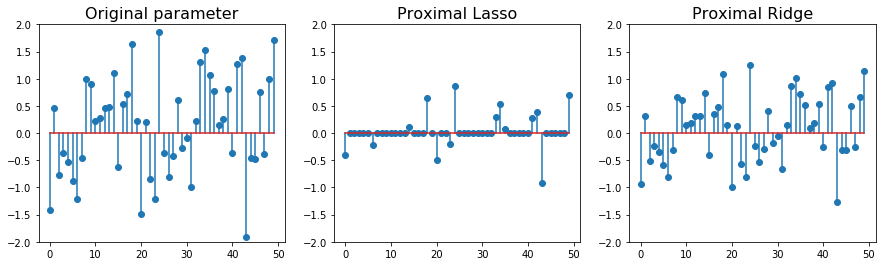

In [86]:
x = randn(50)
l_l1 = 1.
l_l2 = 0.5

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(x)
plt.title("Original parameter", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
plt.stem(prox_lasso(x, s=l_l1))
plt.title("Proximal Lasso", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
plt.stem(prox_ridge(x, s=l_l2))
plt.title("Proximal Ridge", fontsize=16)
plt.ylim([-2, 2])

<div class="alert alert-success">
    <b>Question</b>:
     <ul>
      <li>Comment what you observe (1 or 2 sentences).</li>
    </ul>
</div>

## Comments on proximity operator graph
The original parameters are 50 random numbers from the “standard normal” distribution. 

The Lasso proximity operator regularizes the parameter in the following way (i.e. the returned proximity value): 
- if the original parameter absolute value is big (bigger than s), the original absolute value is reduced by  $s$, with the sign unchanged
- if the original parameter absolute value is small (smaller than s), then it could be neglected and zero is returned

The Lasso regularize the parameter by penalizing the big one and neglect the small one (with $s$ as the threshold). 



The Ridge proximity operator regularizes all the parameters in the same way, i.e. the original parameter is divided by $(1. + s)$, where $s = 0.5$ in this case.

## Part 2: Gradients

The problems we want to minimize take the form:
$$
\arg\min_x f(x) + g(x)
$$
where $f$ is $L$-smooth and $g$ is prox-capable.

Consider the following cases:

**Linear regression**, where 
$$
f(x) = \frac{1}{2n} \sum_{i=1}^n (b_i - a_i^\top x)^2 = \frac{1}{2 n} \| b - A x \|_2^2,
$$
where $n$ is the sample size, $b = [b_1 \cdots b_n]$ is the vector of labels and $A$ is the matrix of features.

**Logistic regression**, where
$$
f(x) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-b_i a_i^\top x)),
$$
where $n$ is the sample size, and where labels $b_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f$ and its gradient

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute on paper the gradient $\nabla f$ of $f$ for both cases (linear and logistic regression)</li>
      <li>Code a function that computes $f$ and its gradient $\nabla f$ in both cases, using the prototypes below.</li>
      <li>Check that these functions are correct by numerically checking the gradient, using the function ``<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.check_grad.html">check_grad</a>`` from ``scipy.optimize``. Remark: use the functions `simu_linreg` and `simu_logreg` to simulate data according to the right model</li>
    </ul>
</div>

In [87]:
def loss_linreg(x):
    """Least-squares loss"""
    return (1. / (2 * n_samples)) * norm(A_lin.dot(x) - b_lin, 2) ** 2

def grad_linreg(x):
    """Leas-squares gradient"""
    return A_lin.T.dot(A_lin.dot(x) - b_lin) / n_samples

def loss_logreg(x):
    """Logistic loss"""
    return 1. / n_samples * np.sum(np.log(1. + np.exp(-b_log * A_log.dot(x))))

def grad_logreg(x):
    """Logistic gradient"""
    c = np.exp(- b_log * A_log.dot(x))
    return 1. / n_samples * np.sum(- b_log * A_log.T * c / (1 + c), axis=1)

In [88]:
A_lin, b_lin = simu_linreg(coefs)
A_log, b_log = simu_logreg(coefs)

from scipy.optimize import check_grad

print(check_grad(loss_linreg, grad_linreg, x))
print(check_grad(loss_logreg, grad_logreg, x))

2.3991189750374206e-06
1.433485260007103e-07


## Part 3: Solvers

We know have a function to compute $f$, $\nabla f$ and $g$ and $\text{prox}_g$. 

We want now to code the Ista and Fista solvers to minimize

$$
\arg\min_x f(x) + g(x)
$$

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Implement functions that compute the Lipschitz constants for linear and 
  logistic regression losses. Note that the operator norm of a matrix can 
  be computed using the function <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html">numpy.linalg.norm</a> (read the documentation
  of the function)</li>
      <li>Finish the functions `ista` and `fista` below that implements the 
  ISTA (Proximal Gradient Descent) and FISTA (Accelerated Proximal 
  Gradient Descent) algorithms</li>
    </ul>
</div>

In [89]:
def lip_linreg(A):
    """Lipschitz constant for linear squares loss"""
    return norm(A, ord = 2) ** 2. / n_samples
    
def lip_logreg(A):
    """Lipschitz constant for logistic loss"""
    return norm(A, ord = 2) ** 2. / (4. * n_samples)
    
def ista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = A.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    if verbose:
        print("Lauching ISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        x = prox_g(x - step * grad_f(x), s)
        
        obj = f(x) + g(x, s)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, objectives, errors

In [90]:
def fista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Accelerated Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    # An extra variable is required for FISTA
    z = x0.copy()
    n_samples, n_features = A.shape
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    t = 1.
    t_new = 1.    
    if verbose:
        print("Lauching FISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        x_new = prox_g(z - step * grad_f(z), s)
        t_new = (1. + (1. + 4. * t ** 2.) ** 0.5) / 2.
        z = x_new + (t - 1.) / t_new * (x_new - x)
        
        x = x_new
        t = t_new    

        obj = f(x) + g(x, s)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, np.array(objectives), np.array(errors)

## Algorithms comparison and numerical experiments

In [91]:
# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
n_iter = 50
s = 1e-2

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute a precise minimum and a precise minimizer of the linear regression with ridge 
  penalization problem using the parameters give above. This can be done by using fista with 
  1000 iterations.</li>
    <li>Compare the convergences of ISTA and FISTA, in terms of distance to the minimum and 
  distance to the minimizer. Do your plots using a logarithmic scale of the y-axis.</li>
    </ul>
</div>

In [92]:
'''
Compute a precise minimum and a precise minimizer of the linear regression with ridge penalization 
problem using the parameters give above. This can be done by using fista with 1000 iterations.
'''
A, b = simu_linreg(coefs)
step = 1 / lip_linreg(A)
ref_x, ref_objectives, ref_errors = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s, 1000, coefs, False)
print ('The precise minimum is: ',  ref_objectives[-1])
print ('The precise minimizer is: ',  ref_x)

The precise minimum is:  0.5067937779175803
The precise minimizer is:  [ 0.91 -0.76  0.71 -0.68  0.63 -0.58  0.52 -0.46  0.46 -0.43  0.35 -0.34
  0.29 -0.22  0.23 -0.1   0.16 -0.21  0.13 -0.1   0.02 -0.01 -0.02 -0.02
 -0.05 -0.07  0.02  0.03 -0.05 -0.    0.08  0.05 -0.05  0.02 -0.06  0.02
  0.01  0.03  0.07 -0.06 -0.01  0.04 -0.06  0.03 -0.04  0.03 -0.   -0.05
  0.03 -0.02]


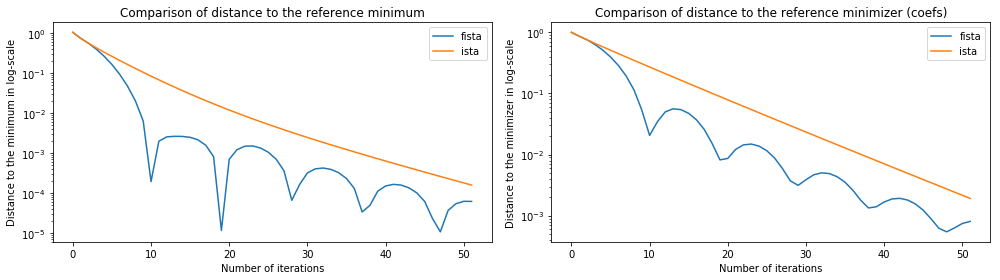

In [93]:
'''
Compare the convergences of ISTA and FISTA, in terms of distance to the minimum and distance to the minimizer. 
Do your plots using a logarithmic scale of the y-axis.
'''

fista_x, fista_objectives, fista_errors = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s, n_iter, ref_x, verbose = False)
ista_x, ista_objectives, ista_errors = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s, n_iter, ref_x, verbose = False)

minimun_f = ref_objectives[-1]

# Distance to the minimum 
fista_dis_minimum = np.abs(fista_objectives - minimun_f)
ista_dis_minimum = np.abs(ista_objectives - minimun_f)

plt.figure(figsize=(14., 4.))
iteration_ids = np.arange(0, n_iter + 2)

plt.subplot(1, 2, 1)
plt.semilogy(iteration_ids, fista_dis_minimum, label="fista")
plt.semilogy(iteration_ids, ista_dis_minimum, label="ista")
plt.xlabel('Number of iterations')
plt.ylabel('Distance to the minimum in log-scale')
plt.legend(loc=1)
plt.title('Comparison of distance to the reference minimum')

#Distance to the minimizer
plt.subplot(1, 2, 2)
plt.semilogy(iteration_ids, fista_errors, label='fista')
plt.semilogy(iteration_ids, ista_errors, label='ista')
plt.xlabel('Number of iterations')
plt.ylabel('Distance to the minimizer in log-scale')
plt.legend(loc=1)
plt.title('Comparison of distance to the reference minimizer (coefs)')

plt.tight_layout()
plt.show()

<b>Discuss the results above :</b>|

As we see from the graph that fista method converges obviously faster than ista method. This is consistent with the theorectical result that ista has a convergence rate of $O(1/k)$ and fista has a covergence rate of $O(\frac{1}{K^2} )$


<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Compare the solution you obtain with ista and fista with the true parameter `coefs` of
  the model. This can be done with `plt.stem` plots.</li>
    <li>In linear regression and logistic regression, study the influence of the correlation 
  of the features on the performance of the optimization algorithms. Explain.</li>
    <li>In linear regression and logistic regression, study the influence of the level of ridge 
  penalization on the performance of the optimization algorithms. Explain.</li>
    <li>In linear regression and logistic regression, compare the performance of the optimization
  algorithms for ridge and lasso penalizations. Explain</li>
    </ul>
</div>

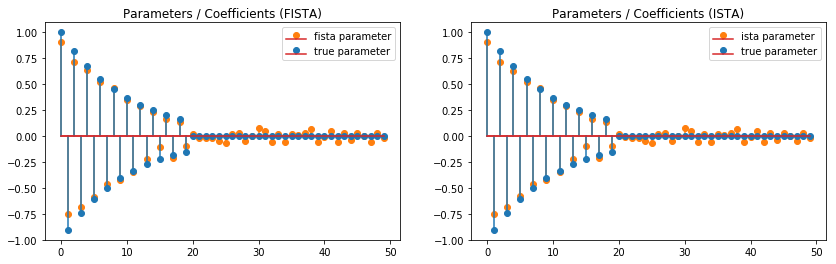

In [94]:
'''
Compare the solution you obtain with ista and fista with the true parameter coefs of the model. 
This can be done with plt.stem plots.
'''

plt.figure(figsize=(14., 4.))
plt.subplot(1, 2, 1)
plt.stem(fista_x, label="fista parameter", linefmt="C1-", markerfmt="C1o")
plt.stem(coefs, label='true parameter')
plt.title("Parameters / Coefficients (FISTA)")
plt.legend(loc=1)

plt.subplot(1, 2, 2)
plt.stem(ista_x, label="ista parameter", linefmt="C1-", markerfmt="C1o")
plt.stem(coefs, label='true parameter')
plt.title("Parameters / Coefficients (ISTA)")
plt.legend(loc=1)
plt.show()

<b>Discuss the results above :</b>

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


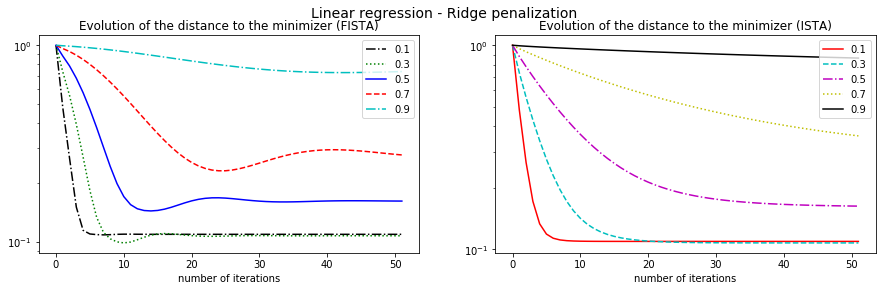

In [95]:
'''
In linear regression and logistic regression, study the influence of the correlation of the features 
on the performance of the optimization algorithms. Explain.
'''

plt.figure(figsize=(15., 4.))
plt.suptitle('Linear regression - Ridge penalization', fontsize=14)

iteration_ids = np.arange(0, n_iter + 2)

#Linear regression
for corr in [0.1, 0.3, 0.5, 0.7, 0.9]:
    A_lin, b_lin = simu_linreg(coefs, corr = corr)
    step = 1 / lip_linreg(A_lin)
    #fista_x_min = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s, 1000, coefs, verbose = False)[0]
    fista_x, fista_objectives, fista_errors = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s, 
                                                    n_iter, coefs, verbose = False)
    plt.subplot(1, 2, 1)
    plt.semilogy(iteration_ids, fista_errors,  next(linecycler),color=next(colors), label = corr)
    plt.legend(loc=1)
    plt.xlabel('number of iterations')
    plt.title("Evolution of the distance to the minimizer (FISTA)")
    
    ista_x_min = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s, 1000, coefs, verbose = False)[0]
    ista_x, ista_objectives, ista_errors = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s, 
                                                n_iter, coefs, verbose = False)
    plt.subplot(1, 2, 2)
    plt.semilogy(iteration_ids, ista_errors, next(linecycler2),color=next(colors2),  label = corr)
    plt.legend(loc=1)
    plt.xlabel('number of iterations')
    plt.title("Evolution of the distance to the minimizer (ISTA)")
    

<b>Discuss the results for Linear Regression :</b>

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


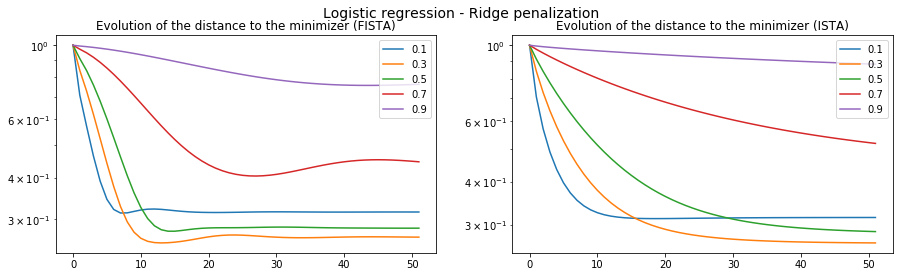

In [96]:
plt.figure(figsize=(15., 4.))
plt.suptitle('Logistic regression - Ridge penalization', fontsize=14)

from itertools import cycle
import itertools
lines = ["-","--","-.",":"]
linecycler = cycle(lines)
linecycler2 = cycle(lines)
colors = cycle(['g', 'b', 'r', 'c', 'm', 'y', 'k'])
colors2 = cycle(['g', 'b', 'r', 'c', 'm', 'y', 'k'])


#Logistic regression
for corr in [0.1, 0.3, 0.5, 0.7, 0.9]:
    A_log, b_log = simu_logreg(coefs, corr = corr)
    step = 1 / lip_logreg(A_log)
    #fista_x_min = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s, 1000, coefs, verbose = False)[0]
    fista_x, fista_objectives, fista_errors = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s, 
                                                    n_iter, coefs, verbose = False)
    plt.subplot(1, 2, 1)
    plt.semilogy(iteration_ids, fista_errors, label = corr)
    plt.legend(loc=1)
    plt.title("Evolution of the distance to the minimizer (FISTA)")
    
    ista_x_min = ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s, 1000, coefs, verbose = False)[0]
    ista_x, ista_objectives, ista_errors = ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s, 
                                                n_iter, coefs, verbose = False)
    plt.subplot(1, 2, 2)
    plt.semilogy(iteration_ids, ista_errors, label = corr)
    plt.legend(loc=1)
    plt.title("Evolution of the distance to the minimizer (ISTA)")

## Comments on the correlation influence

Clearly, we see correlation have similar effect on both linear and logistic regreesion, only differing in scale.  We see that the higher the correlations, the slower it converges to the true solution (coefs). This is because when the correlations increases, the simulated features gradually change from less correlated to highly correlated, and when the correlation increases to one, then all the features in matrix A will then be identical, and only the random term in the simulation functions really plays a role. Therefore it will be much faster and also more accurate to sovle the optimization problem (when the number of different features are significant, i.e. correlation is small).

<b>Discuss the results for Logistic Regression :</b>

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


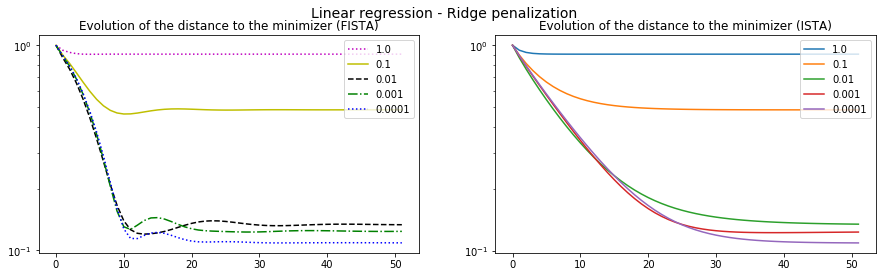

In [78]:
'''
In linear regression and logistic regression, study the influence of the level of ridge penalization 
on the performance of the optimization algorithms. Explain.
'''

plt.figure(figsize=(15., 4.))
plt.suptitle('Linear regression - Ridge penalization', fontsize=14)

#Linear regression
for s in [1., 1e-1, 1e-2, 1e-3, 1e-4]:
    A_lin, b_lin = simu_linreg(coefs)
    step = 1 / lip_linreg(A_lin)
    #fista_x_min = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s, 1000, coefs, verbose = False)[0]
    fista_x, fista_objectives, fista_errors = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s, 
                                                    n_iter, coefs, verbose = False)
    plt.subplot(1, 2, 1)
    plt.semilogy(iteration_ids, fista_errors,  next(linecycler2),color=next(colors2), label = s)
    plt.legend(loc=1)
    plt.title("Evolution of the distance to the minimizer (FISTA)")
    
    ista_x_min = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s, 1000, coefs, verbose = False)[0]
    ista_x, ista_objectives, ista_errors = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s, 
                                                n_iter, coefs, verbose = False)
    plt.subplot(1, 2, 2)
    plt.semilogy(iteration_ids, ista_errors, label = s)
    plt.legend(loc=1)
    plt.title("Evolution of the distance to the minimizer (ISTA)")
    
plt.show()    

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


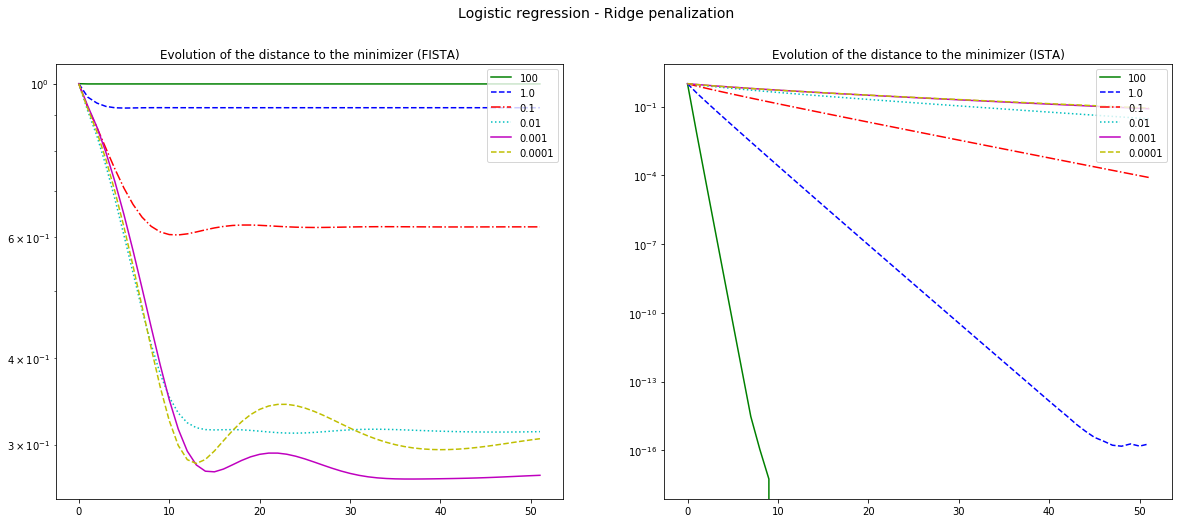

In [76]:
plt.figure(figsize=(20., 8.))
plt.suptitle('Logistic regression - Ridge penalization', fontsize=14)

from itertools import cycle
import itertools
lines = ["-","--","-.",":"]
linecycler = cycle(lines)
linecycler2 = cycle(lines)
colors = cycle(['g', 'b', 'r', 'c', 'm', 'y', 'k'])
colors2 = cycle(['g', 'b', 'r', 'c', 'm', 'y', 'k'])

#Logistic regression
for s in [100, 1., 1e-1, 1e-2, 1e-3, 1e-4]:
    A_log, b_log = simu_logreg(coefs)
    step = 1 / lip_logreg(A_log)
    fista_x_min = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s, 1000, coefs, verbose = False)[0]
    fista_x, fista_objectives, fista_errors = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s, 
                                                    n_iter, coefs, verbose = False)
    plt.subplot(1, 2, 1)
    plt.semilogy(iteration_ids, fista_errors, next(linecycler),color=next(colors), label = s)
    plt.legend(loc=1)
    plt.title("Evolution of the distance to the minimizer (FISTA)")
    
    ista_x_min = ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s, 1000, coefs, verbose = False)[0]
    ista_x, ista_objectives, ista_errors = ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s, 
                                                n_iter, ista_x_min, verbose = False)
    plt.subplot(1, 2, 2)
    plt.semilogy(iteration_ids, ista_errors, next(linecycler2),color=next(colors2), label = s)
    plt.legend(loc=1)
    plt.title("Evolution of the distance to the minimizer (ISTA)")

    

<b>Discuss the results above :</b>

## Comments on the penalization level
Clearly, we see that penalization level has similar effect on both linear and logistic regreesion. When the penalization level is high, we see quite high convergence rate, i.e. the result approaches to the true coefs very fast. And when the penalization level is low, the convergence rate is quite low. That makes sense because when the penalization level is extremly low, we could intepret as there is no penalty, and when there is no penalty, the solution should be exactly matching the true coefs if the optimization problem find the optimal solution. And when the penalization level is high, the penalization term (g(x)) gradually dominates over the real objective function term (f(x)), and that is why we see that the distance to the minimizer increases and so does the error when the penalization level increases.

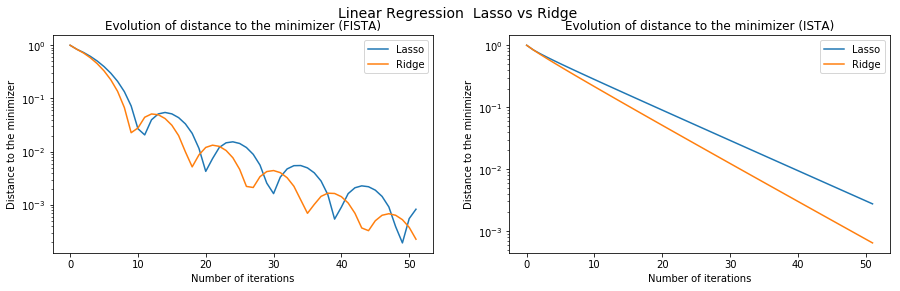

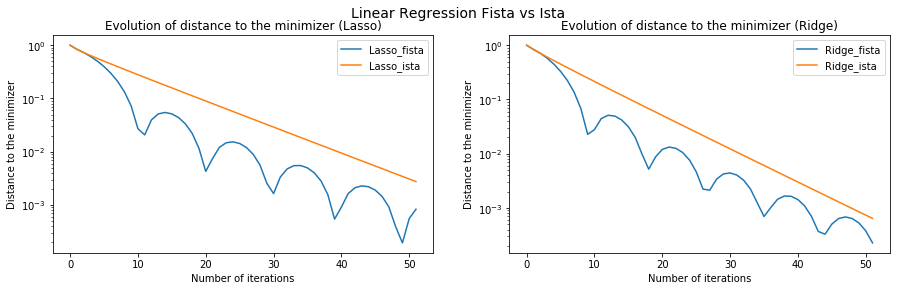

In [56]:
'''
In linear regression and logistic regression, compare the performance of the optimization algorithms for ridge 
and lasso penalizations. Explain
'''
A_lin, b_lin = simu_linreg(coefs)
step = 1 / lip_linreg(A_lin)
s=0.05

lin_lasso_x_fista = fista(x0, loss_linreg, grad_linreg, lasso, prox_lasso, step, s, 1000, coefs, verbose = False)[0]
lin_lasso_fista_x, lin_lasso_fista_objectives, lin_lasso_fista_errors = fista(x0, loss_linreg, grad_linreg, lasso, prox_lasso, step, s, 
                                                n_iter, lin_lasso_x_fista, verbose = False)

lin_ridge_x_fista = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s, 1000, coefs, verbose = False)[0]
lin_ridge_fista_x, lin_ridge_fista_objectives, lin_ridge_fista_errors = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s, 
                                                n_iter, lin_ridge_x_fista, verbose = False)

lin_lasso_x_ista = ista(x0, loss_linreg, grad_linreg, lasso, prox_lasso, step, s, 1000, coefs, verbose = False)[0]
lin_lasso_ista_x, lin_lasso_ista_objectives, lin_lasso_ista_errors = ista(x0, loss_linreg, grad_linreg, lasso, prox_lasso, step, s, 
                                                n_iter, lin_lasso_x_ista, verbose = False)

lin_ridge_x_ista = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s, 1000, coefs, verbose = False)[0]
lin_ridge_ista_x, lin_ridge_ista_objectives, lin_ridge_ista_errors = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s, 
                                                n_iter, lin_ridge_x_ista, verbose = False)

plt.figure(figsize=(15., 4.))
plt.suptitle('Linear Regression  Lasso vs Ridge', fontsize=14)

plt.subplot(1, 2, 1)
plt.semilogy(iteration_ids, lin_lasso_fista_errors, label='Lasso')
plt.semilogy(iteration_ids, lin_ridge_fista_errors, label='Ridge')
plt.xlabel('Number of iterations')
plt.ylabel('Distance to the minimizer')
plt.legend(loc=1)
plt.title('Evolution of distance to the minimizer (FISTA)')

plt.subplot(1, 2, 2)
plt.semilogy(iteration_ids, lin_lasso_ista_errors, label='Lasso')
plt.semilogy(iteration_ids, lin_ridge_ista_errors, label='Ridge')
plt.xlabel('Number of iterations')
plt.ylabel('Distance to the minimizer')
plt.legend(loc=1)
plt.title('Evolution of distance to the minimizer (ISTA)')
plt.show()

plt.figure(figsize=(15., 4.))
plt.suptitle('Linear Regression Fista vs Ista', fontsize=14)

plt.subplot(1, 2, 1)
plt.semilogy(iteration_ids, lin_lasso_fista_errors, label='Lasso_fista')
plt.semilogy(iteration_ids, lin_lasso_ista_errors, label='Lasso_ista')
plt.xlabel('Number of iterations')
plt.ylabel('Distance to the minimizer')
plt.legend(loc=1)
plt.title('Evolution of distance to the minimizer (Lasso)')


plt.subplot(1, 2, 2)
plt.semilogy(iteration_ids, lin_ridge_fista_errors, label='Ridge_fista')
plt.semilogy(iteration_ids, lin_ridge_ista_errors, label='Ridge_ista')
plt.xlabel('Number of iterations')
plt.ylabel('Distance to the minimizer')
plt.legend(loc=1)
plt.title('Evolution of distance to the minimizer (Ridge)')
plt.show()

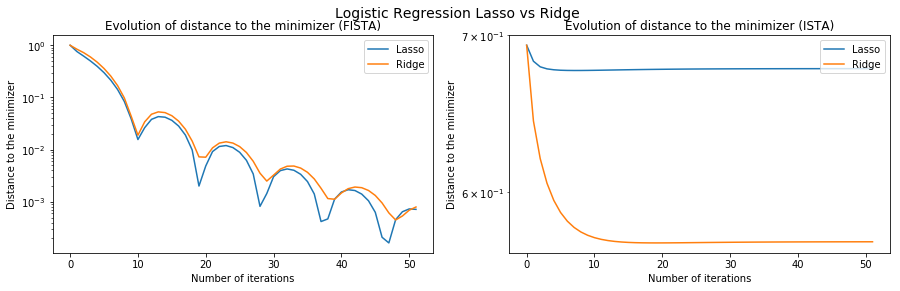

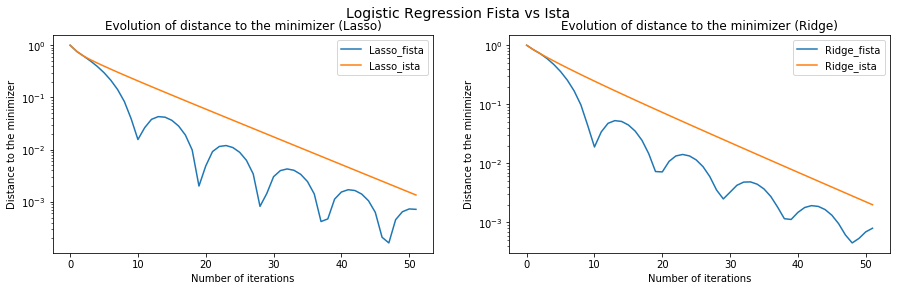

In [54]:
A_log, b_log = simu_logreg(coefs)
step = 1 / lip_logreg(A_log)
s=0.05


log_lasso_x_fista = fista(x0, loss_logreg, grad_logreg, lasso, prox_lasso, step, s, 1000, coefs, verbose = False)[0]
log_lasso_fista_x, log_lasso_fista_objectives, log_lasso_fista_errors = fista(x0, loss_logreg, grad_logreg, lasso, prox_lasso, step, s, 
                                                n_iter, log_lasso_x_fista, verbose = False)

log_ridge_x_fista = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s, 1000, coefs, verbose = False)[0]
log_ridge_fista_x, log_ridge_fista_objectives, log_ridge_fista_errors = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s, 
                                                n_iter, log_ridge_x_fista, verbose = False)

log_lasso_x_ista = ista(x0, loss_logreg, grad_logreg, lasso, prox_lasso, step, s, 1000, coefs, verbose = False)[0]
log_lasso_ista_x, log_lasso_ista_objectives, log_lasso_ista_errors = ista(x0, loss_logreg, grad_logreg, lasso, prox_lasso, step, s, 
                                                n_iter, log_lasso_x_ista, verbose = False)

log_ridge_x_ista = ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s, 1000, coefs, verbose = False)[0]
log_ridge_ista_x, log_ridge_ista_objectives, log_ridge_ista_errors = ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s, 
                                                n_iter, log_ridge_x_ista, verbose = False)

plt.figure(figsize=(15., 4.))
plt.suptitle('Logistic Regression Lasso vs Ridge', fontsize=14)

plt.subplot(1, 2, 1)
plt.semilogy(iteration_ids, log_lasso_fista_errors, label='Lasso')
plt.semilogy(iteration_ids, log_ridge_fista_errors, label='Ridge')
plt.xlabel('Number of iterations')
plt.ylabel('Distance to the minimizer')
plt.legend(loc=1)
plt.title('Evolution of distance to the minimizer (FISTA)')

plt.subplot(1, 2, 2)
plt.semilogy(iteration_ids, log_lasso_ista_objectives, label='Lasso')
plt.semilogy(iteration_ids, log_ridge_ista_objectives, label='Ridge')
plt.xlabel('Number of iterations')
plt.ylabel('Distance to the minimizer')
plt.legend(loc=1)
plt.title('Evolution of distance to the minimizer (ISTA)')
plt.show()


plt.figure(figsize=(15., 4.))
plt.suptitle('Logistic Regression Fista vs Ista', fontsize=14)

plt.subplot(1, 2, 1)
plt.semilogy(iteration_ids, log_lasso_fista_errors, label='Lasso_fista')
plt.semilogy(iteration_ids, log_lasso_ista_errors, label='Lasso_ista')
plt.xlabel('Number of iterations')
plt.ylabel('Distance to the minimizer')
plt.legend(loc=1)
plt.title('Evolution of distance to the minimizer (Lasso)')


plt.subplot(1, 2, 2)
plt.semilogy(iteration_ids, log_ridge_fista_errors, label='Ridge_fista')
plt.semilogy(iteration_ids, log_ridge_ista_errors, label='Ridge_ista')
plt.xlabel('Number of iterations')
plt.ylabel('Distance to the minimizer')
plt.legend(loc=1)
plt.title('Evolution of distance to the minimizer (Ridge)')
plt.show()

<b>Discuss the results above :</b>

## Comments on the performance of ridge and lasso on linear and logistic regression

As we see from the graph that fista method converges obviously faster than ista method, regardless which regression and which penalizer. This is consistent with the theorectical result that ista has a convergence rate of $O(1/k)$ and fista has a covergence rate of $O(\frac{1}{K^2} )$


Ridge seems to outperform the Lasso slightly, especialy for the logistic regression. This is becase Ridge will keep all the parameters regardless the magnitude of the original parameters, however Lasso will discard those small parameters (whose absolute value smaller than $s$).  However, this also depends on the choice of the penalization level $s$. When $s$ is small, we could hardly observer any difference bewtween the result of ridge and lasso. 